In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynbody

from michaels_functions import center_and_r_vir, remove_bulk_velocity

In [2]:
path = "bulk1/data_2/hydro_59/output/"
data = pynbody.load(path + "output_00050")

aexp = data.properties['a']
data.physical_units()

print path
print "a =", aexp
print "z =", 1./aexp -1

bulk1/data_2/hydro_59/output/
a = 0.600005205268
z = 0.666652207716


In [3]:
r_vir = center_and_r_vir(data, aexp, path)

('shifting on Stars:', SimArray([ 0.00308878, -0.03302971, -0.04676732], 'kpc'))
('virial radius:', SimArray(152.40432611, 'kpc'))


In [4]:
r_e = 0.1 * r_vir
print r_e

15.240432611151682


In [5]:
sph_5 = pynbody.filt.Sphere(radius = '%f kpc' %(r_e*1.4))
region = data[sph_5]

In [6]:
rho = region.gas["rho"].in_units("m_p cm^-3")

In [7]:
Z = region.gas["metal"]

In [8]:
f = open(data.filename + "/info_"+data.filename[-5:]+".txt","r")
lines = f.readlines()
f.close()

for line in lines:
    if line[0:13]=="unit_l      =":
        print line[:-1]
        unit_l = float(line[14:-1])
    if line[0:13]=="unit_d      =":
        print line[:-1]
        unit_d = float(line[14:-1])
    if line[0:13]=="unit_t      =":
        print line[:-1]
        unit_t = float(line[14:-1])
    if line[0:13]=="omega_b     =":
        print line[:-1]
        omega_b = float(line[14:-1])

omega_b     =  0.450000017881393E-01
unit_l      =  0.682025380323961E+26
unit_d      =  0.123367583719985E-28
unit_t      =  0.163687521954501E+18


In [33]:
turb = np.sqrt( region.g["turb"] * 2./3. ) * unit_l / unit_t / 1e5
turb = pynbody.array.SimArray(turb, units = "cm s**-1")
c_s = np.sqrt(region.gas["p"] / region.gas["rho"])
c_s = c_s.in_units('cm s**-1')
mach_no = turb / c_s
region.g["mach"] = mach_no.in_units("1")

In [34]:
turb

SimArray([29.15456777, 44.73850117, 68.11498304, ..., 29.26368001,
          16.37539853, 25.15026196], 'cm s**-1')

In [35]:
c_s

SimArray([ 3276673.11939746, 12738195.66072513,  9202021.83758316, ...,
          14469186.19848063, 13460450.29314729, 14119970.07822348], 'cm s**-1')

In [36]:
mach_no

SimArray([8.89761252e-06, 3.51215371e-06, 7.40217577e-06, ...,
          2.02248279e-06, 1.21655652e-06, 1.78118380e-06], '1.00e+00')

In [41]:
m_p_1 = pynbody.array.SimArray(1.0, pynbody.units.m_p)
n_H_mean_arr = rho / m_p_1

In [42]:
n_H_mean_arr

SimArray([0.00242818, 0.00016367, 0.00038948, ..., 0.00032273, 0.00023647,
          0.00029291], 'cm**-3')

In [39]:
m_p = pynbody.array.SimArray(1.672621777e-24, "g")
K_b = pynbody.array.SimArray(1.38064852e-16, "cm**2 g s**-2 K**-1")
G = pynbody.array.SimArray(6.67259e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")

In [26]:
def make_pdf(s, s_bar, sigma_s):
    pdf = (1/np.sqrt(2*np.pi*(sigma_s**2))) * (np.exp(-0.5*(((s - s_bar)/sigma_s)**2)))
    return pdf

In [27]:
def calc_lambda_jeans(n_H):
    lambda_jeans = ((np.sqrt(K_b * T_mean / m_p)) / np.sqrt(4* np.pi * G * n_H * m_p))
    return lambda_jeans

In [28]:
def calc_n_LW(n_H, G_o, lambda_jeans):
    kappa = 1000 * m_p
    rad_field_outside = G_o #in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    n_LW = rad_field_outside * exp_tau
    return n_LW

In [31]:
def calc_n_LW_ss(n_H, n_H2, G_o, lambda_jeans):
    kappa = 1000 * m_p
    rad_field_outside = G_o #in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    N_H2 = n_H2*lambda_jeans
    term1 = (0.965/((1+(N_H2/5e14))**2))
    term2 = ( (0.035/np.sqrt(1+(N_H2/5e14))) * np.exp(-1*np.sqrt(1+(N_H2/5e14))/1180) )
    S_H2 = term1 + term2
    n_LW_ss = rad_field_outside * exp_tau * S_H2
    return n_LW_ss, S_H2, N_H2

In [43]:
def calc_X_H2(n_H, Z, n_LW):
    DC = 1.7e-11
    CC = 2.5e-17            #cm3 s-1
    numerator = DC * n_LW
    denominator = CC * Z * n_H
    X_H2 = 1 / (2 + (numerator/denominator) )
    return X_H2

In [51]:
def self_shielding_iterations(n_H, G_o, lambda_jeans, Z):    
    n_LW = calc_n_LW(n_H, G_o, lambda_jeans)
    X_H2_a = calc_X_H2(n_H, Z, n_LW)
    n_H2_a = n_H * X_H2_a

    n_LW_1, S_H2_1, N_H2_1 = calc_n_LW_ss(n_H, n_H2_a, G_o, lambda_jeans)
    X_H2_1 = calc_X_H2(n_H, Z, n_LW_1)
    n_H2_1 = n_H * X_H2_1

    n_LW_2, S_H2_2, N_H2_2 = calc_n_LW_ss(n_H, n_H2_1, G_o, lambda_jeans)
    X_H2_2 = calc_X_H2(n_H, Z, n_LW_2)
    n_H2_2 = n_H * X_H2_2

    n_LW_3, S_H2_3, N_H2_3 = calc_n_LW_ss(n_H, n_H2_2, G_o, lambda_jeans)
    X_H2_3 = calc_X_H2(n_H, Z, n_LW_3)
    n_H2_3 = n_H * X_H2_3

    n_LW_4, S_H2_4, N_H2_4 = calc_n_LW_ss(n_H, n_H2_3, G_o, lambda_jeans)
    X_H2_4 = calc_X_H2(n_H, Z, n_LW_4)
    n_H2_4 = n_H * X_H2_4

    n_LW_5, S_H2_5, N_H2_5 = calc_n_LW_ss(n_H, n_H2_4, G_o, lambda_jeans)
    X_H2_5 = calc_X_H2(n_H, Z, n_LW_5)
    n_H2_5 = n_H * X_H2_5

    n_LW_6, S_H2_6, N_H2_6 = calc_n_LW_ss(n_H, n_H2_5, G_o, lambda_jeans)
    X_H2_6 = calc_X_H2(n_H, Z, n_LW_6)
    n_H2_6 = n_H * X_H2_6

    n_LW_7, S_H2_7, N_H2_7 = calc_n_LW_ss(n_H, n_H2_6, G_o, lambda_jeans)
    X_H2_7 = calc_X_H2(n_H, Z, n_LW_7)
    n_H2_7 = n_H * X_H2_7

    n_LW_8, S_H2_8, N_H2_8 = calc_n_LW_ss(n_H, n_H2_7, G_o, lambda_jeans)
    X_H2_8 = calc_X_H2(n_H, Z, n_LW_8)
    n_H2_8 = n_H * X_H2_8

    n_LW_9, S_H2_9, N_H2_9 = calc_n_LW_ss(n_H, n_H2_8, G_o, lambda_jeans)
    X_H2_9 = calc_X_H2(n_H, Z, n_LW_9)
    n_H2_9 = n_H * X_H2_9

    n_LW_10, S_H2_10, N_H2_10 = calc_n_LW_ss(n_H, n_H2_9, G_o, lambda_jeans)
    X_H2_10 = calc_X_H2(n_H, Z, n_LW_10)
    n_H2_10 = n_H * X_H2_10

    n_LW_ss, S_H2, N_H2 = calc_n_LW_ss(n_H, n_H2_10, G_o, lambda_jeans)
    X_H2 = calc_X_H2(n_H, Z, n_LW_ss)
    n_H2 = n_H * X_H2
    
    return n_LW, X_H2_a, n_H2_a, n_LW_ss, S_H2, N_H2, X_H2, n_H2

KeyboardInterrupt: 

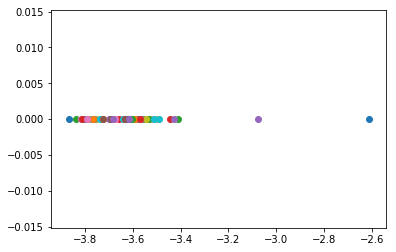

In [52]:
fig, ax = plt.subplots()
Z_z = 1
G_o = 1
for m in range(0, len(mach_no)):
    M = mach_no[m]
    sigma_s = np.sqrt(np.log(1 + ((0.3 * M)**2)))
    s_bar = -0.5*(sigma_s**2)
    smin = -4*sigma_s + s_bar
    smax = 4*sigma_s + s_bar
    ds = (smax - smin)/1000
    for y in range(0, len(n_H_mean_arr)):
        n_H_mean = n_H_mean_arr[y]
        s = np.zeros(1000)
        pdf = np.zeros(1000)
        lambda_jeans = np.zeros(1000)
        X_H2 = np.zeros(1000)
        n_H = np.zeros(1000)
        n_LW = np.zeros(1000)
        n_LW_ss = np.zeros(1000)
        S_H2 = np.zeros(1000)
        N_H2 = np.zeros(1000)
        X_H2_a = np.zeros(1000)
        n_H2_a = np.zeros(1000)
        n_H2 = np.zeros(1000)
        integral1 = 0
        X_H2_bar = np.zeros(1000)
        for i in range(0, 1000):
            s[i] = smin + i*ds
            pdf[i] = make_pdf(s[i], s_bar, sigma_s)
            n_H[i] = n_H_mean * np.exp(s[i])
            lambda_jeans[i] = calc_lambda_jeans(n_H[i])
            n_LW[i], X_H2_a[i], n_H2_a[i], n_LW_ss[i], S_H2[i], N_H2[i], X_H2[i], n_H2[i] = self_shielding_iterations(n_H[i], G_o, lambda_jeans[i], Z_z)             
            integral1 += np.exp(s[i]) * pdf[i] * ds
        X_H2_bar = integral1 * X_H2
        plt.scatter(np.log10(n_H_mean), X_H2_bar[i])
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_H2_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_H2_bar - M=varied, Z=1, G_o=1')
plt.savefig('log(n_H_mean)vsX_H2_bar--M.png')